In [1]:
import sys, os


import networkx as nx
from geopy.distance import great_circle
import geohash
import geopandas as gpd
import osmnx as ox
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import math
import contextily as cx
from shapely.geometry import Polygon,Point
from shapely import wkt,ops
import colorsys
from sklearn.preprocessing import StandardScaler
from scipy import spatial
import random

import contextily as ctx
from matplotlib.colors import Normalize
from scipy.stats import pearsonr
from numpy import dot
from numpy.linalg import norm
import pickle

In [2]:
from io import BytesIO
import palettable

In [3]:

# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.sans-serif'] = ['Arial'] + ['DejaVu Sans',
                              'Bitstream Vera Sans',
                              'Computer Modern Sans Serif',
                              'Lucida Grande',
                              'Verdana',
                              'Geneva',
                              'Lucid',
                              'Arial',
                              'Helvetica',
                              'Avant Garde',
                              'sans-serif']

In [4]:
country_name = 'colombia'
country_abbrv = 'co'

In [5]:
daily_od_fname = f'od_{country_abbrv}_agg5_3h.csv'
daily_od = pd.read_csv(daily_od_fname)
geohashes = list(set(daily_od.start_geohash5.unique()).union(set(daily_od.end_geohash5.unique())))
geohash_coord = {gh:geohash.decode(gh) for gh in geohashes}
geohash_bbox = {gh: geohash.bbox(gh) for gh in geohashes}
unique_times = list(np.unique([row.local_time[-19:] for i, row in daily_od.iterrows()]))
str_time_dict = {t:i for i, t in enumerate(unique_times)}
daily_od['time_id'] = daily_od.local_time.apply(lambda x: str_time_dict[x[-19:]])
daily_od['m_length_km'] = daily_od.m_length_m/1000.
daily_od['neighbours'] = daily_od['start_geohash5'].apply(lambda x: geohash.neighbors(x))
daily_od['wtd_length'] = daily_od['m_length_m'] * daily_od['trip_count']

R = daily_od.groupby(['start_geohash5', 'end_geohash5', 'time_id']).agg({'trip_count':'mean',
                                                                            'wtd_length':'mean'}).reset_index()
R['trip_count'] = R['trip_count'].round().astype(int)
R['avg_len_real'] = R['wtd_length']/R['trip_count']
R['short'] = R['avg_len_real'].apply(lambda x: x<=5000)

/home/jupyter-niyer/README
niyer SunSquare1!


In [6]:
time_str_dict = {v:k for k,v in str_time_dict.items()}

In [7]:
weekday_eff = pd.read_csv('estimated_routes/'+country_abbrv+'_agg_weekday_eff.csv')
urbanicity_df = pd.read_csv(f'{country_abbrv}_urbanicity_v2.csv')
weekday_eff = weekday_eff.groupby(['start_geohash5', 'end_geohash5', 'time_id', 'iteration']).agg({'sp_lengths':'mean',
                                                                                               'origin':'count'}, axis=1).reset_index()
weekday_eff = weekday_eff.groupby(['start_geohash5', 'end_geohash5', 'time_id']).agg({'sp_lengths':'mean',
                                                                                 'origin':'first'}, axis=1).reset_index()
weekday_eff = weekday_eff.merge(urbanicity_df, how='left', left_on='start_geohash5', right_on='gh5')
weekday_eff = weekday_eff.merge(R, how='left', on=['start_geohash5'	,'end_geohash5',	'time_id'],  suffixes=['_est', '_real'])
# weekday_eff['short_est'] = weekday_eff['sp_lengths'].apply(lambda x: x<=5000)
# weekday_eff['short_real'] = weekday_eff['avg_len_real'].apply(lambda x: x<=5000)
weekday_eff['delta'] = weekday_eff['avg_len_real'] - weekday_eff['sp_lengths']

/home/jupyter-niyer/README
niyer SunSquare1!
/home/jupyter-niyer/README
niyer SunSquare1!


In [8]:
city_boundaries = minio_helper.read_file(f'netmob_2024/processed_data/{country_abbrv}_urban_bounds.csv', obj_type='pickle')


/home/jupyter-niyer/README
niyer SunSquare1!


In [9]:
cid_name = {'2_co':'Cartagena', '10_co':'Barranquilla', '17_co':'Cali', '32_co':'Medellin', '13_co':'Bogota',
 '7_mx':'Guadalajara', '37_mx':'Monterrey', '14_mx':'Puebla', '42_mx':'Santiago de Querétaro', '1_mx':'Mexico City',
 '14_in':'Kolkata', '99_in':'Hyderabad', '81_in':'Bengaluru', '32_in':"New Delhi", '13_in':'Mumbai'
}

In [10]:
country_cids = {'co':[2, 10,17,32,13],
                'mx':[7,37,14,42,1],
                'in':[14,99,81,32,13]}

In [11]:
city_boundaries

,geometry,cluster,geom_centroid
0,"POLYGON ((-74.26758 4.61426, -74.22363 4.61426...",13,POINT (-74.0866 4.75129)
1,"POLYGON ((-75.67383 6.19629, -75.62988 6.19629...",32,POINT (-75.58071 6.22035)
2,"POLYGON ((-76.55273 3.20801, -76.55273 3.25195...",17,POINT (-76.50391 3.41309)
3,"POLYGON ((-74.83887 10.89844, -74.88281 10.898...",10,POINT (-74.8114 10.92316)
4,"POLYGON ((-73.08105 7.03125, -73.125 7.03125, ...",19,POINT (-73.15186 7.09229)
5,"POLYGON ((-73.69629 4.04297, -73.69629 4.08691...",25,POINT (-73.60596 4.104)
6,"POLYGON ((-75.41016 10.37109, -75.36621 10.371...",2,POINT (-75.49561 10.39795)


In [12]:
import math

def deg_to_rad(deg):
    return deg * math.pi / 180

def rad_to_deg(rad):
    return rad * 180 / math.pi

def calculate_bearing(pt1, pt2):
    lat1, lon1 = pt1
    lat2, lon2 = pt2
    lat1_rad = deg_to_rad(lat1)
    lon1_rad = deg_to_rad(lon1)
    lat2_rad = deg_to_rad(lat2)
    lon2_rad = deg_to_rad(lon2)
    
    delta_lon = lon2_rad - lon1_rad
    x = math.sin(delta_lon) * math.cos(lat2_rad)
    y = math.cos(lat1_rad) * math.sin(lat2_rad) - (math.sin(lat1_rad) * math.cos(lat2_rad) * math.cos(delta_lon))
    initial_bearing_rad = math.atan2(x, y)
    initial_bearing_deg = rad_to_deg(initial_bearing_rad)
    compass_bearing = (initial_bearing_deg + 360) % 360
    
    return compass_bearing
    
def round_to_nearest_45(bearing):
    return round(bearing / 45) * 45



In [13]:
temp = []
for gh in geohashes:
    gh_eff = weekday_eff[(weekday_eff.start_geohash5 == gh)]
    gh_eff = gh_eff[gh_eff.start_geohash5 != gh_eff.end_geohash5]
    if len(gh_eff) >0:
        print(gh, gh_eff.area_type.iloc[0], len(gh_eff), len(gh_eff.end_geohash5.unique()))
        temp.append(gh_eff)
temp = pd.concat(temp)

d3f72 urban 10 4
d3h0s rural 2 1
d3f71 urban 14 3
d3kkw rural 5 1
d3f6f urban 1 1
d345n urban 7 3
d2fkd rural 7 2
d2f93 rural 6 3
d3fy6 urban 21 5
d29ef urban 18 4
d2gke urban 2 1
d3gpz rural 5 1
d21p1 rural 3 1
d2f50 rural 2 1
d3h11 rural 1 1
d3f73 urban 14 4
d29e4 urban 13 3
d3d19 rural 5 1
d29u0 rural 4 1
d2g69 urban 64 16
d2gz6 rural 5 1
d29e6 urban 39 7
d2f5w rural 5 1
d3472 urban 46 11
d3fyd urban 14 5
d34k1 urban 3 2
d2gzd rural 6 2
d2g63 urban 75 17
d29ed urban 40 8
d21nc rural 5 1
d3f74 urban 10 4
d3k00 urban 10 2
d2d2y rural 7 2
d3kmn rural 7 1
d2g7e urban 2 1
d3fy3 urban 18 5
d23ft rural 1 1
d2g6d urban 87 19
d2g64 urban 57 17
d2g7g urban 1 1
d2f90 rural 11 4
d3due rural 1 1
d2g3b urban 8 3
d3grb rural 6 1
d2fb3 rural 1 1
d29sp rural 3 1
d345z urban 1 1
d2g6g urban 39 11
d3ggs rural 6 2
d2g68 urban 25 7
d2f1y rural 7 2
d2exk urban 7 1
d2g71 urban 16 5
d3k64 rural 1 1
d344z urban 9 3
d3kmj rural 1 1
d345p urban 44 9
d29e7 urban 14 3
d37bx urban 11 3
d372p rural 2 1
d3ggt rura

In [14]:
def get_orientation(s_gh5, e_gh5):
    lat_s, lon_s = geohash_coord[s_gh5]
    lat_e, lon_e = geohash_coord[e_gh5]
    

    if lat_s < lat_e:
        if lon_s == lon_e:
            return 'n'
        elif lon_s < lon_e:
            return 'ne'
        else:
            return 'nw'

    if lat_s > lat_e:
        if lon_s == lon_e:
            return 's'
        elif lon_s < lon_e:
            return 'se'
        else:
            return 'sw'
    
    if lat_s == lat_e:
        if lon_s == lon_e:
            return None
        elif lon_s < lon_e:
            return 'e'
        else:
            return 'w'
        
    

In [15]:
gh_neighbours = []
for gh in temp.start_geohash5.unique():
    for o,ghn in zip(['w', 'e', 's', 'sw', 'se', 'n', 'nw', 'ne'],
                    geohash.neighbors(gh)):
        
        gh_neighbours += [[gh, ghn, o]]

gh_neighbours = pd.DataFrame(gh_neighbours, columns=['start_geohash5', 'end_geohash5', 'dir'])
temp = temp.merge(gh_neighbours, how='left', on=['start_geohash5', 'end_geohash5'])
temp['dir'] = temp.apply(lambda row: get_orientation(row.start_geohash5, row.end_geohash5) if pd.isnull(row.dir) else row.dir, axis=1)


In [16]:
deg_ax = {0: [0,1], 45: [0,2], 90:[1,2], 135:[2,2], 180:[2,1], 225:[2,0], 270:[1,0], 315:[0,0]}
ax_deg = {tuple(v):k for k,v in deg_ax.items()}

# GAUSSIAN AND GRADIENT

In [ ]:
country_pt_density = {}
country_road_density = {}
for ca in ['in', 'mx', 'co']:
    for tt in ['pt']:
        with open(f'{ca}_{tt}_density.pkl', 'rb') as handle:
            df = pickle.load(handle)

        df = df.rename({'gh':'gh5'},axis=1)
        urbanicity_df = pd.read_csv(f'{country_abbrv}_urbanicity_v2.csv')
        weekday_eff = pd.read_csv('estimated_routes/'+country_abbrv+'_agg_weekday_eff.csv')
        weekday_eff = weekday_eff[['gh5', 'time_id', 'delta']]
        weekend_eff = pd.read_csv('estimated_routes/'+country_abbrv+'_agg_weekend_eff.csv')
        weekend_eff = weekend_eff[['gh5', 'time_id', 'delta']]
        weekend_eff['time_id'] = weekend_eff['time_id'] + 8
        eff_df = pd.concat([weekday_eff, weekend_eff])
        
        
        df['no_pts'] = [len(xx) for xx in df.points]
        df['no_pts_norm'] = (df['no_pts']-df['no_pts'].min())/(df['no_pts'].max()-df['no_pts'].min())
        df['density_norm'] = (df['density']-df['density'].min())/(df['density'].max()-df['density'].min())
        df['score'] = (0.5*df['no_pts_norm']) + (0.5 * df['coverage_ratio']) # mean
        df = df.merge(urbanicity_df, how='left', on='gh5')
        df = eff_df.merge(df, how='left', on='gh5')
        if tt=='road':
            country_road_density[ca] = df
        else:
            country_pt_density[ca] = df

In [20]:
import geohash
import pandas as pd
import numpy as np
from geographiclib.geodesic import Geodesic


In [21]:
def geohash_bbox(geohash_code):
    return geohash.bbox(geohash_code)



In [22]:
def get_grid(gdf, data_col, ret_geohash=False):
    geohash_precision = len(gdf['gh5'].iloc[0])
    gdf[['latitude', 'longitude']] = gdf['gh5'].apply(lambda x: geohash.decode(x)).apply(pd.Series)
    
    min_lat, max_lat = gdf['latitude'].min(), gdf['latitude'].max()
    min_lon, max_lon = gdf['longitude'].min(), gdf['longitude'].max()
    
    lat_steps = sorted(gdf.latitude.unique())[::-1]
    lon_steps = sorted(gdf.longitude.unique())
    # Create a 2D grid and initialize with NaN
    grid = pd.DataFrame(np.nan, index=lat_steps, columns=lon_steps)
    if ret_geohash:
        gh_grid = pd.DataFrame('', index=lat_steps, columns=lon_steps, dtype=str)
    for _, row in gdf.iterrows():
        lat = row['latitude']
        lon = row['longitude']
        value = row[data_col]
        
        closest_lat = min(lat_steps, key=lambda x: abs(x - lat))
        closest_lon = min(lon_steps, key=lambda x: abs(x - lon))

        if ret_geohash:
            gh_grid.loc[closest_lat, closest_lon] = row.gh5

        grid.loc[closest_lat, closest_lon] = value
    if ret_geohash:
        return grid, gh_grid
    return grid

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter


In [24]:
def get_gradient(data, col='None', time_id='None', plot=False):
    
    city_data = data.fillna(0).values
    
    sigma = 1  # Standard deviation for Gaussian kernel
    smoothed_grid = gaussian_filter(city_data, sigma=sigma)
    
    grad_ns, grad_ew = np.gradient(smoothed_grid)
    
    mean_grad_ns = np.mean(grad_ns, axis=1)
    mean_grad_ew = np.mean(grad_ew, axis=0)
    
    # print(f"Mean North-South Gradient: {mean_grad_ns}")
    # print(f"Mean East-West Gradient: {mean_grad_ew}")

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        
        axs[0].imshow(grad_ns, cmap='RdYlBu', origin='lower', aspect='auto')
        axs[0].set_title("North-South Gradient")
        axs[0].set_xlabel("East-West (columns)")
        axs[0].set_ylabel("North-South (rows)")
        
        axs[1].imshow(grad_ew, cmap='RdYlBu', origin='lower', aspect='auto')
        axs[1].set_title("East-West Gradient")
        axs[1].set_xlabel("East-West (columns)")
        axs[1].set_ylabel("North-South (rows)")
        fig.suptitle(col + ': ' + time_id)
        
        plt.colorbar(axs[0].imshow(grad_ns, cmap='RdYlBu', origin='lower', aspect='auto'), ax=axs[0])
        plt.colorbar(axs[1].imshow(grad_ew, cmap='RdYlBu', origin='lower', aspect='auto'), ax=axs[1])
        
        plt.tight_layout()
        plt.savefig(f'{col}_{time_id}.png')
        plt.show()
    return mean_grad_ns, mean_grad_ew


## Build Vector Fields and compare angular difference

In [19]:
ca = 'co'
country_abbrv = ca
urbanicity_df = pd.read_csv(f'{country_abbrv}_urbanicity_v2.csv')
cids = urbanicity_df[urbanicity_df.area_type=='urban'].groupby('cluster_id').count().sort_values('gh5', ascending=False)[:5].index.tolist()
cids
urbanicity_df[urbanicity_df.area_type=='urban'].groupby('cluster_id').count().sort_values('gh5', ascending=False)[:5]

/home/jupyter-niyer/README


,gh5,area_type,closest_city
cluster_id,,,
13,55,55,0
32,21,21,0
17,18,18,0
10,16,16,0
2,9,9,0


In [38]:
def real_vector_field(data, scale, vmin, vmax, plot=False, save=None, cmap='magma'):
    df = pd.DataFrame(data.fillna(0) )
    df.index = range(len(data.index))
    df.columns = range(len(data.columns))
    sigma = 1
    grid = gaussian_filter(df, sigma=sigma)
    neighborhood_offsets = [(-1, 1), (0, 1), (1, 1),
                            (-1, 0),         (1, 0),
                            (-1, -1), (0, -1), (1, -1)]
    vf_mtx = np.zeros((grid.shape[0], grid.shape[1], 2))
    vf_component_vectors = [[[] for _ in range(grid.shape[1])] for _ in range(grid.shape[0])]
    hypes = []
    for r in range(grid.shape[0]):
        for c in range(grid.shape[1]):
            U = []
            V = []
            for dx, dy in neighborhood_offsets:
                new_r = r - dy
                new_c = c + dx
                if (new_r in range(grid.shape[0])) and (new_c in range(grid.shape[1])):
                    hypotenuse = grid[new_r, new_c]
                    dist = math.sqrt((0-dx)**2 + (0-dy)**2)
                    gravity_model = hypotenuse * grid[r][c]/dist**2
                    hypes.append(gravity_model)
                    rad = math.atan2(dx, dy)
                    deg = math.degrees(rad)%360
                    x_unit = math.sin(rad) * gravity_model ## bc 0 is oriented on the y axis, so if rad ~ 90 deg, this should be non-zero
                    y_unit = math.cos(rad) * gravity_model
                    U.append(x_unit)
                    V.append(y_unit)
            vf_mtx[r][c] = np.array([np.sum(U), np.sum(V)])
            vf_component_vectors[r][c] = list(zip(U,V))
  


    vf = {'vf': vf_mtx, 'components_vf':vf_component_vectors}
    vmin,vmax =  np.min(hypes), np.max(hypes)
    
    X, Y = np.meshgrid(np.arange(grid.shape[1]), np.arange(grid.shape[0]))
    vf['X'], vf['Y'] = X, Y
    lats = data.index.tolist()
    lons = data.columns.tolist()
    lon_grid, lat_grid = np.meshgrid(lons, lats) 
    vf['lats'], vf['lons'] = lat_grid, lon_grid
    
    U =  np.array([np.array([item[0] for item in inner]) for inner in vf_mtx])
    V =  np.array([np.array([item[1] for item in inner]) for inner in vf_mtx])
    vf['U'], vf['V'] = U, V
    norm = Normalize(vmin=0, vmax=0.5)

    if plot:
        fig,ax = plt.subplots(figsize=(10,10))
        q=ax.quiver(lon_grid, lat_grid, U, V, grid, angles='xy', scale_units='xy', scale=scale, cmap=cmap, norm=norm)
        ax.set_xlim(min(lons), max(lons))
        ax.set_ylim(min(lats), max(lats))
        ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.CartoDB.Positron)
        ax.axis('off')

        
        plt.show()
    return vf

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special
def get_real_similarity(vf1, vf2, title='', normalise=True, save=None):
    U1, U2, V1, V2 = vf1['U'], vf2['U'], vf1['V'], vf2['V']
    X_orig, Y_orig = vf1['X'], vf1['Y']
    U_shape = (len(U1), len(U1[0]))
    angular_diff,angular_diff_int = np.full(U_shape, np.nan),np.full(U_shape, np.nan)
    dot_product = U1 * U2 + V1 * V2
    magnitude_1 = np.sqrt(U1**2 + V1**2)
    magnitude_2 = np.sqrt(U2**2 + V2**2)
    cos_theta = dot_product / (magnitude_1 * magnitude_2 + 1e-8) 
    
    threshold = 1e-4  
    valid_mask = (magnitude_1 > threshold) & (magnitude_2 > threshold)

    angular_diff_int[valid_mask] = np.arccos(np.clip(cos_theta[valid_mask], -1, 1))  
    angular_diff = np.arccos(np.clip(cos_theta, -1, 1))  # Radians

    angular_diff_degrees_int = np.degrees(angular_diff_int)
    angular_diff_degrees = np.degrees(angular_diff)

    delta_x = X_orig[0, 1] - X_orig[0, 0]  
    delta_y = Y_orig[1, 0] - Y_orig[0, 0] 
    integral_angle_diff = np.nansum(angular_diff_degrees_int) * delta_x * delta_y  
    if normalise:
        integral_angle_diff /= U1.size
    print("Integral of angular differences:", np.nanmean(angular_diff_degrees))
    

    magnitude_diff = np.sqrt((U1 - U2)**2 + (V1 - V2)**2)
    return np.nanmean(angular_diff_degrees), angular_diff_degrees

In [28]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import osmnx as ox
from shapely.geometry import box


In [24]:
def explain_vector(data, vf, row, col, gdf_edges, scale, loc_maxR, loc_maxC):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1,projection=ccrs.PlateCarree())
    gdf_edges.plot(ax=ax, lw=.05, color='k', zorder=0)

    df = pd.DataFrame(data.fillna(0) )
    filtered_df = df.iloc[row-1:row+2, col-1:col+2]
    filtered_gdf = []
    for lat,r in filtered_df.iterrows():
        for lon, pt in zip(filtered_df.columns, list(r)):
            gh = geohash.encode(lat	,lon, precision=5)
            filtered_gdf += [[pt, gh, geohash_polygon(gh)]]
    filtered_gdf = gpd.GeoDataFrame(filtered_gdf,columns=['pt_score','gh5', 'geometry'], crs='epsg:4326')
    filtered_gdf.plot('pt_score',alpha=0.7, ax=ax, zorder=1, cmap='viridis', vmin=0, vmax=1, ec='k')
    
    # ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.CartoDB.Positron)
    # ax.add_feature(cfeature.LAND, zorder=0, edgecolor='k', facecolor='white', linewidth=0.1)
    # ax.add_feature(cfeature.STATES, zorder=0, edgecolor='k', facecolor='white', linewidth=0.1)

    sigma = 1
    grid = gaussian_filter(df, sigma=sigma)

    components = vf['components_vf'][row][col]
    print(vf['components_vf'][row][col][0], len(components))
    max_val = grid[loc_maxR][loc_maxC]

    print([filtered_df.index[1] for _ in range(8)],)
    hl,hal =3,3
    ax.quiver([filtered_df.columns[1] for _ in range(8)], [filtered_df.index[1] for _ in range(8)], [comp[0] for comp in components], [comp[1] for comp in components], 
              scale=scale, width=0.015, headlength=hl, headaxislength=hal)
    ax.quiver([filtered_df.columns[1]], [filtered_df.index[1]], [vf['vf'][row][col][0]], [vf['vf'][row][col][1]], scale=scale, color='white',
               width=0.0125,headlength=hl, headaxislength=hal, **{'edgecolor':'black', 'lw':.5})
    
    # ax.quiver([1.5], [1.5], [(loc_maxC-col)*max_val], [(loc_maxR-row)*max_val], scale=1, color='orange', width=0.0125)
    ax.axis('off')
   

## RUN FROM HERE IF REGENERATING VIZ

In [ ]:
country_abbrv ='co'

ca = country_abbrv
cid_integral = {}
cid_integral_gh = {}
for city_id in country_cids[country_abbrv]:
    time_eff_grid = {}
    time_pt_grid = {}
    cid_integral[city_id] = []
    cid_integral_gh[city_id] = []
    for i in range(16):
        pt_density = country_pt_density[ca][(country_pt_density[ca].cluster_id==city_id)].groupby('gh5').agg({'score':'mean'}).reset_index()
        eff_df = country_pt_density[ca][(country_pt_density[ca].cluster_id==city_id) & (country_pt_density[ca].time_id==i)]

        if len(eff_df)==0:
            print(city_id, i, 'CHECK THIS')
            cid_integral[city_id].append(np.nan)
            continue
        bogota_grid_pt, gh_grid = get_grid(pt_density, 'score', ret_geohash=True)
        bogota_grid_eff_v1 = get_grid(eff_df, 'delta')
    
        bogota_grid_eff = pd.DataFrame(np.nan, columns=bogota_grid_pt.columns, index=bogota_grid_pt.index)
        bogota_grid_eff.loc[bogota_grid_eff_v1.index, bogota_grid_eff_v1.columns] = bogota_grid_eff_v1.values
    
        time_eff_grid[i] = bogota_grid_eff
        time_pt_grid[i] = bogota_grid_pt


        vf_pt =  real_vector_field(time_pt_grid[i], scale = 4, vmin=0, vmax=0.13, plot=True, cmap='viridis')
        vf_eff =  real_vector_field(time_eff_grid[i], scale =7000000, vmin=5000000, vmax=200000000, plot=True, cmap='Oranges')
        angular_diff_avg, angular_diff_all = get_real_similarity(vf_pt,vf_eff)
        print(angular_diff_avg)
        cid_integral[city_id].append(angular_diff_avg)
        print(type(pd.DataFrame(angular_diff_all, index=bogota_grid_eff.index, columns=bogota_grid_eff.columns)))
        cid_integral_gh[city_id].append(pd.DataFrame(angular_diff_all, index=bogota_grid_eff.index, columns=bogota_grid_eff.columns))
        print()

## Calculate average angular diff

In [ ]:

avg_int_df = []
for cid,integral in cid_integral.items():

    
    mini , maxi = min(integral), max(integral)
    integral_norm = [(i-mini)/(maxi-mini) for i in integral]

    xs = range(len(integral))
    ys = integral

    avg_int_df += [[cid] + ys ]
    sns.lineplot(y=interpolate.BSpline(*tck)(xnew), x=xnew,ax=ax, label=cid)
    ax.set_ylabel('Integral of Angular Difference')
    # break
ax.set_xlim((0,15))
avg_int_df = pd.DataFrame(avg_int_df, columns=['cid'] + list(range(16)))

In [ ]:
avg_int_df.to_csv(f'processing/{ca}_vector_field_integral_avg.csv')
with open(f'processing/{ca}_vector_field_cid_integral.pkl', 'wb') as handle:
    pickle.dump(aavg_int_df, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [71]:
gh_angular_diff = []

for cid, angular_diff_all in cid_integral_gh.items():
    for t, angular_diff_df in enumerate(angular_diff_all):
        for lat,row in angular_diff_df.iterrows():
            for lon in angular_diff_df.columns:
                gh = geohash.encode(lat	,lon, precision=5)
                gh_angular_diff.append([t, gh, 180-row[lon]])
        
urbanicity_df = pd.read_csv(f'{country_abbrv}_urbanicity_v2.csv')

gh_angular_diff = pd.DataFrame(gh_angular_diff, columns=['timestamp', 'geohash', 'inefficiency_score'])
gh_angular_diff = gh_angular_diff[gh_angular_diff.geohash.isin(list(urbanicity_df[urbanicity_df.area_type=='urban'].gh5))]
geohash_bbox = {gh: geohash.bbox(gh) for gh in list(gh_angular_diff.geohash.unique())} 
    
geohash_poly = pd.DataFrame([[gh, Polygon([(geohash_bbox[gh]['w'], geohash_bbox[gh]['s']),
                                     (geohash_bbox[gh]['e'], geohash_bbox[gh]['s']),
                                     (geohash_bbox[gh]['e'], geohash_bbox[gh]['n']), 
                                     (geohash_bbox[gh]['w'], geohash_bbox[gh]['n'])])] for gh in list(gh_angular_diff.geohash.unique())], columns=['geohash', 'coordinates'])
geohash_poly['coordinates'] = geohash_poly.apply(lambda row: ";".join([str(coord[0]) + ',' + str(coord[1]) for coord in list(row['coordinates'].exterior.coords)]), axis=1)
gh_angular_diff = gh_angular_diff.merge(geohash_poly, how='left', on='geohash')
gh_angular_diff[['geohash','coordinates','inefficiency_score','timestamp']].to_csv(f'{country_abbrv}_transit_ineff_data_viz.csv')

/home/jupyter-niyer/README
/home/jupyter-niyer/README
Variable data is successfully uploaded as 'netmob_2024/processed_data/mx_transit_ineff_data_viz.csv' to bucket 'niyer-processed'.


In [214]:
def geohash_polygon(gh):
    return Polygon([(geohash_bbox(gh)['w'], geohash_bbox(gh)['s']),
                                     (geohash_bbox(gh)['e'], geohash_bbox(gh)['s']),
                                     (geohash_bbox(gh)['e'], geohash_bbox(gh)['n']), 
                                     (geohash_bbox(gh)['w'], geohash_bbox(gh)['n'])])

In [213]:
df = pd.DataFrame(time_pt_grid[i].fillna(0) )
filtered_df = df.iloc[row-1:row+2, col-1:col+2]
filtered_gdf = []
for lat,r in filtered_df.iterrows():
    for lon, pt in zip(filtered_df.columns, list(r)):
        gh = geohash.encode(lat	,lon, precision=5)
        filtered_gdf += [[pt, gh, geohash_polygon(gh)]]
filtered_gdf = gpd.GeoDataFrame(filtered_gdf,columns=['pt_score','gh5', 'geometry'], crs='epsg:4326')

G = ox.graph_from_bbox(bbox=(filtered_gdf.total_bounds[3], filtered_gdf.total_bounds[1], filtered_gdf.total_bounds[2], filtered_gdf.total_bounds[0]),
                      network_type='drive')
gdf_nodes, gdf_edges = ox.graph_to_gdfs(
        G,
        nodes=True, edges=True,
        node_geometry=True,
        fill_edge_geometry=True)

/tmp/ipykernel_60995/3873513175.py:1: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = ox.graph_from_bbox(bbox=(filtered_gdf.total_bounds[3], filtered_gdf.total_bounds[1], filtered_gdf.total_bounds[2], filtered_gdf.total_bounds[0]),


(-0.03058569413991348, 0.030585694139913484) 8
[4.68017578125, 4.68017578125, 4.68017578125, 4.68017578125, 4.68017578125, 4.68017578125, 4.68017578125, 4.68017578125]
/home/jupyter-niyer/README
Variable data is successfully uploaded as 'netmob_2024/final_figures/processing/explain_vf_toy.pdf' to bucket 'niyer-processed'.


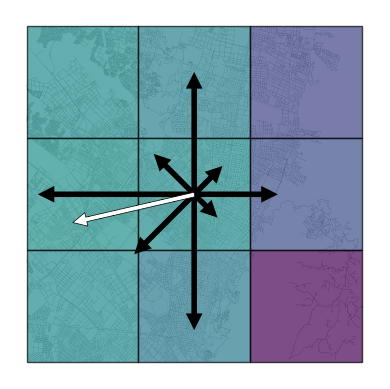

In [215]:
explain_vector(time_pt_grid[i], vf_pt,9, 5, gdf_edges, scale=0.28, loc_maxR=9,loc_maxC=4)

In [ ]:
city_gdf =[]
for lat,r in df.iterrows():
    for lon, pt in zip(df.columns, list(r)):
        gh = geohash.encode(lat	,lon, precision=5)
        city_gdf += [[pt, gh, geohash_polygon(gh)]]
city_gdf = gpd.GeoDataFrame(city_gdf,columns=['pt_score','gh5', 'geometry'], crs='epsg:4326')
city_gdf

/home/jupyter-niyer/README
Variable data is successfully uploaded as 'netmob_2024/final_figures/processing/validation_new_vf_transit.pdf' to bucket 'niyer-processed'.


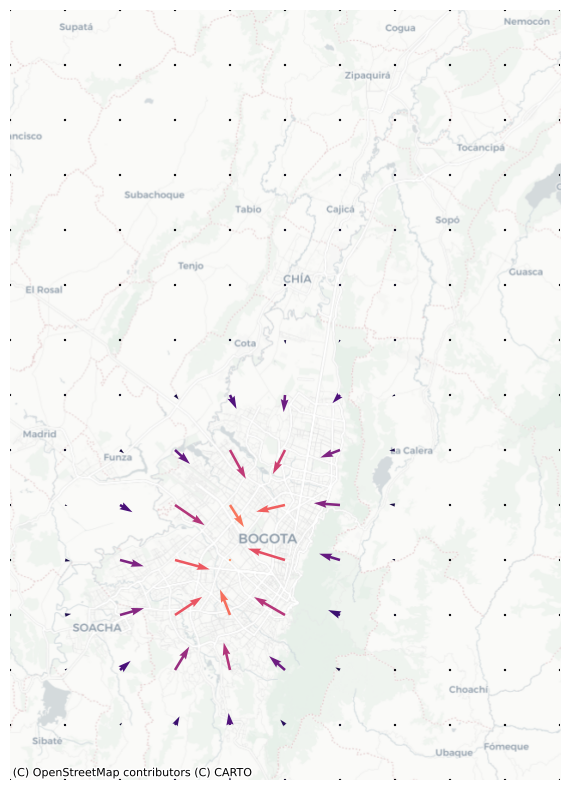

In [271]:
vf_pt =  real_vector_field(time_pt_grid[i], scale = 4, vmin=0, vmax=0.13, plot=True, save='validation_new_vf_transit')


/home/jupyter-niyer/README
Variable data is successfully uploaded as 'netmob_2024/final_figures/processing/validation_new_vf_mobEff.pdf' to bucket 'niyer-processed'.


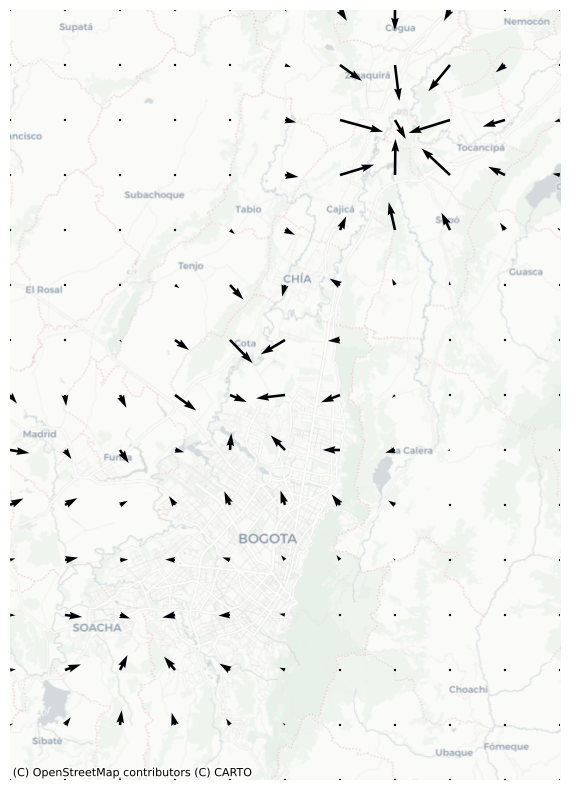

In [270]:
vf_pt =  real_vector_field(time_eff_grid[i], scale = 60000000, vmin=0, vmax=0.13, plot=True, save='validation_new_vf_mobEff')
